# Data Extraction
A partir de um arquivo .html, extrai a tabela contendo as datas e os números de cada sorteio.

In [58]:
# implementar

time: 536 µs (started: 2023-07-26 17:10:13 +00:00)


# Data Transformation
A partir da tabela que contém os sorteios, cria uma segunda contendo dados estatísticos e outras informações adicionais sobre os sorteios. Esta etapa será o equivalente à engenharia de atributos, mas ao contrário do que é feito normalmente, será feita antes da análise exploratória porque o conjunto de dados precisa ser criado primeiro.

In [59]:
%pip install ipython-autotime  --upgrade

time: 6.34 s (started: 2023-07-26 17:10:15 +00:00)


In [60]:
from google.colab import drive, files
import joblib
import pandas as pd
drive.mount('/content/drive', force_remount=True)
%load_ext autotime

Mounted at /content/drive
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.7 s (started: 2023-07-26 17:10:21 +00:00)


In [61]:
raffles = joblib.load("/content/drive/MyDrive/datasets/loterias/loterias-lotofacil.pkl")
#dataset['Data_Sorteio'] = pd.to_datetime(dataset['Data_Sorteio'], format="%d/%m/%Y")
#dataset = dataset.set_index('Data_Sorteio')
raffles = raffles.drop(['Data_Sorteio'], axis=1)
raffles.head()

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
0,2.0,3.0,5.0,6.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,20.0,23.0,24.0,25.0
1,1.0,4.0,5.0,6.0,7.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0
2,1.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,14.0,16.0,17.0,20.0,23.0,24.0
3,1.0,2.0,4.0,5.0,8.0,10.0,12.0,13.0,16.0,17.0,18.0,19.0,23.0,24.0,25.0
4,1.0,2.0,4.0,8.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0,25.0


time: 90.7 ms (started: 2023-07-26 17:10:25 +00:00)


In [62]:
from sklearn.base     import BaseEstimator, TransformerMixin
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

import itertools
import numpy as np

time: 595 µs (started: 2023-07-26 17:10:25 +00:00)


In [63]:
class DescriptiveStatistics(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_ = X.copy()
    X_['min']  = X_.apply(lambda y: y.min(), axis=1)
    X_['max']  = X_.apply(lambda y: y.max(), axis=1)
    X_['mean'] = X_.apply(lambda y: y.mean(), axis=1)
    X_['std']  = X_.apply(lambda y: y.std(), axis=1)
    return X_

time: 2.64 ms (started: 2023-07-26 17:10:25 +00:00)


In [64]:
class EvenAmount(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def even_amount(self, raffle):
    raffle_size = 15
    even = itertools.filterfalse(lambda x: x % 2 != 0, raffle.iloc[:raffle_size])
    return len(list(even))

  def transform(self, X, y=None):
    X = X.copy()
    raffle_size = 15
    X['even_amount'] = X.apply(self.even_amount, axis=1)
    return X

time: 1.77 ms (started: 2023-07-26 17:10:25 +00:00)


In [65]:
class Quartiles(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X_ = X.iloc[:, 0: 15].copy()
    X['quartile_1_5']   = X_.apply(lambda y: ((y >= 1) & (y <= 5)).sum(), axis=1)
    X['quartile_6_10']  = X_.apply(lambda y: ((y >= 6) & (y <= 10)).sum(), axis=1)
    X['quartile_11_15'] = X_.apply(lambda y: ((y >= 11) & (y <= 15)).sum(), axis=1)
    X['quartile_16_20'] = X_.apply(lambda y: ((y >= 16) & (y <= 20)).sum(), axis=1)
    X['quartile_21_25'] = X_.apply(lambda y: ((y >= 21) & (y <=25)).sum(), axis=1)
    return X

time: 1.76 ms (started: 2023-07-26 17:10:25 +00:00)


In [66]:
class RaffleRemover(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    return X.iloc[:, 15:]

time: 1.12 ms (started: 2023-07-26 17:10:25 +00:00)


In [67]:
class RepeatedOne(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def match_numbers(self, X):
      raffle_x = set(X[['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8', 'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15']])
      raffle_y = set(X[['lag1_Bola1', 'lag1_Bola2', 'lag1_Bola3', 'lag1_Bola4', 'lag1_Bola5', 'lag1_Bola6', 'lag1_Bola7', 'lag1_Bola8', 'lag1_Bola9', 'lag1_Bola10', 'lag1_Bola11', 'lag1_Bola12', 'lag1_Bola13', 'lag1_Bola14', 'lag1_Bola15']])
      return len(raffle_x.intersection(raffle_y))

  def transform(self, X, y=None):
    X_ = X.copy()
    for name in X_.columns:
      X_['lag1_' + name] = X_[name].shift(1)
    X['repeated'] = X_.apply(self.match_numbers, axis=1)
    return X

time: 2.08 ms (started: 2023-07-26 17:10:25 +00:00)


In [68]:
class QuartilesPatternMapping(BaseEstimator, TransformerMixin):
  """
  Codifica cada sequência de valores presentes nos atributos quartile_1_5 até quartile_21_25 em apenas um número.
  Assim, é possível criar um atributo substituindo os cinco.
  """
  def fit(self, X, y=None):
    X_ = X[['quartile_1_5', 'quartile_6_10', 'quartile_11_15', 'quartile_16_20', 'quartile_21_25']]
    self.quartiles = list()
    X_.apply(lambda y: self.quartiles.append(np.array2string(y.to_numpy())), axis=1) # transforma cada sequência de cinco números em uma string
    patterns_unique = {item for item in self.quartiles} # set comprehension
    self.patterns_map = {value: index for index, value in enumerate(patterns_unique)} # dicionário padrão:id
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X['quartiles_codified'] = pd.Series(self.quartiles).replace(self.patterns_map)
    X = X.drop(['quartile_1_5', 'quartile_6_10', 'quartile_11_15', 'quartile_16_20', 'quartile_21_25'], axis=1)
    return X

time: 1.62 ms (started: 2023-07-26 17:10:25 +00:00)


## Pipeline completo

In [69]:
steps = [('descriptivestatistics', DescriptiveStatistics()),
         ('repeated', RepeatedOne()),
         ('evenodd', EvenAmount()),
         ('quartiles', Quartiles()),
         ('raffleremover', RaffleRemover()),
         ('quartilespatternmapping', QuartilesPatternMapping())]

pipeline_full = Pipeline(steps=steps)
dataset = pipeline_full.fit_transform(raffles)

time: 16.7 s (started: 2023-07-26 17:10:25 +00:00)


# EDA

In [70]:
dataset

,min,max,mean,std,repeated,even_amount,quartiles_codified
0,2.0,25.0,13.294118,7.954020,0,8,327
1,1.0,24.0,12.352941,7.561055,9,6,23
2,1.0,24.0,12.176471,7.334329,11,9,307
3,1.0,25.0,13.117647,8.344652,9,8,86
4,1.0,25.0,13.411765,8.189368,11,7,296
...,...,...,...,...,...,...,...
2706,1.0,25.0,11.882353,7.645701,10,7,107
2707,1.0,25.0,14.000000,8.845072,8,7,314
2708,1.0,25.0,13.294118,8.716210,11,5,225
2709,1.0,25.0,12.058824,8.076623,9,8,169


time: 19.4 ms (started: 2023-07-26 17:10:42 +00:00)


In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   min                 2711 non-null   float64
 1   max                 2711 non-null   float64
 2   mean                2711 non-null   float64
 3   std                 2711 non-null   float64
 4   repeated            2711 non-null   int64  
 5   even_amount         2711 non-null   int64  
 6   quartiles_codified  2711 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 148.4 KB
time: 25.1 ms (started: 2023-07-26 17:10:42 +00:00)


In [72]:
dataset.describe()

,min,max,mean,std,repeated,even_amount,quartiles_codified
count,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000
mean,1.628181,24.400221,13.022544,7.732113,8.957580,7.192918,176.133899
std,0.929867,0.943566,1.087299,0.552496,1.234815,1.254380,103.093571
min,1.000000,18.000000,8.941176,5.093588,0.000000,3.000000,0.000000
25%,1.000000,24.000000,12.294118,7.388151,8.000000,6.000000,89.000000
50%,1.000000,25.000000,13.000000,7.783400,9.000000,7.000000,184.000000
75%,2.000000,25.000000,13.823529,8.137231,10.000000,8.000000,255.000000
max,7.000000,25.000000,16.294118,9.123528,14.000000,11.000000,352.000000


time: 53.7 ms (started: 2023-07-26 17:10:42 +00:00)


In [73]:
dataset.nunique()

min                      7
max                      8
mean                   108
std                   1787
repeated                11
even_amount              9
quartiles_codified     353
dtype: int64

time: 7.93 ms (started: 2023-07-26 17:10:42 +00:00)


## Data Visualization

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
%matplotlib inline

time: 3.68 ms (started: 2023-07-26 17:10:42 +00:00)


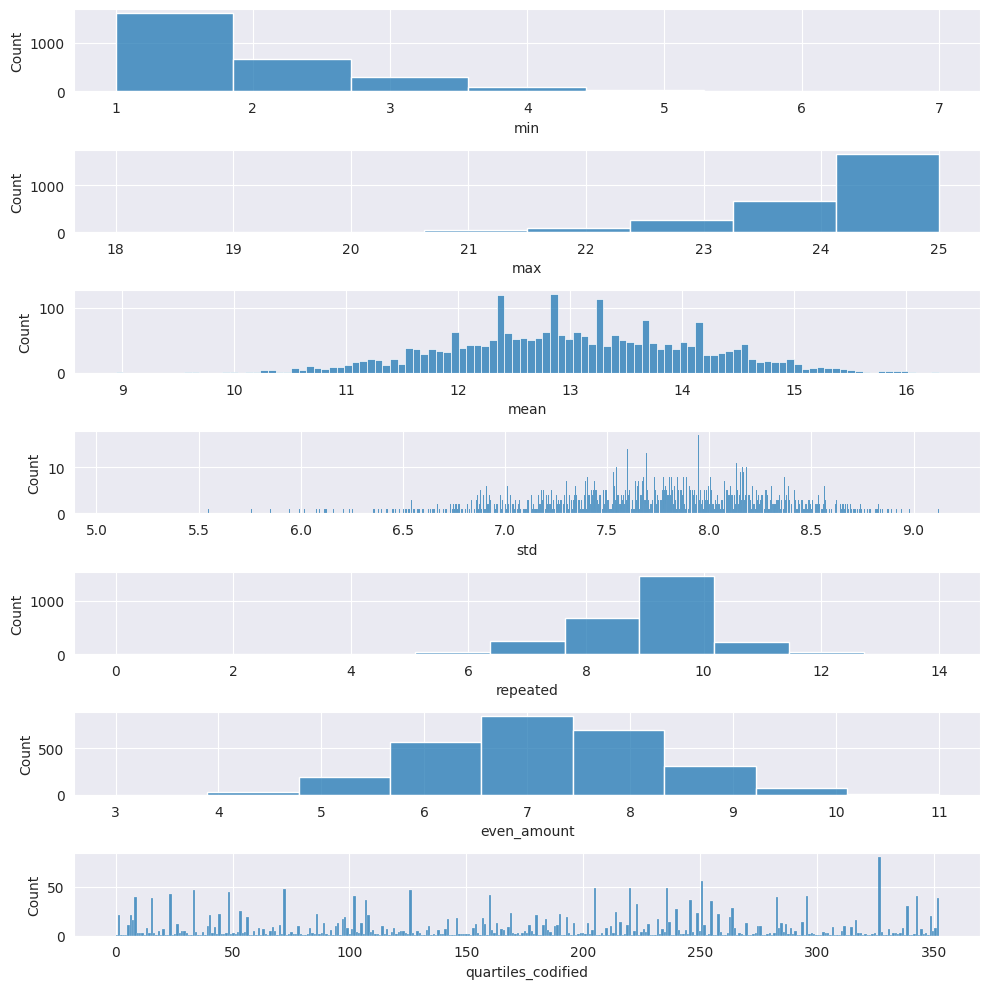

time: 15 s (started: 2023-07-26 17:10:42 +00:00)


In [75]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(7, 1, figsize=(10, 10))
for axis, col_name in zip(ax.ravel(), dataset.columns):
  sns.histplot(data=dataset, x=col_name, bins=dataset[col_name].nunique(), ax=axis)
plt.tight_layout()
plt.show()

# Train/Test Split

In [76]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

time: 1.8 ms (started: 2023-07-26 17:10:57 +00:00)


In [77]:
tss = TimeSeriesSplit(n_splits=2, test_size=200, gap=1)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]

time: 3.06 ms (started: 2023-07-26 17:10:57 +00:00)


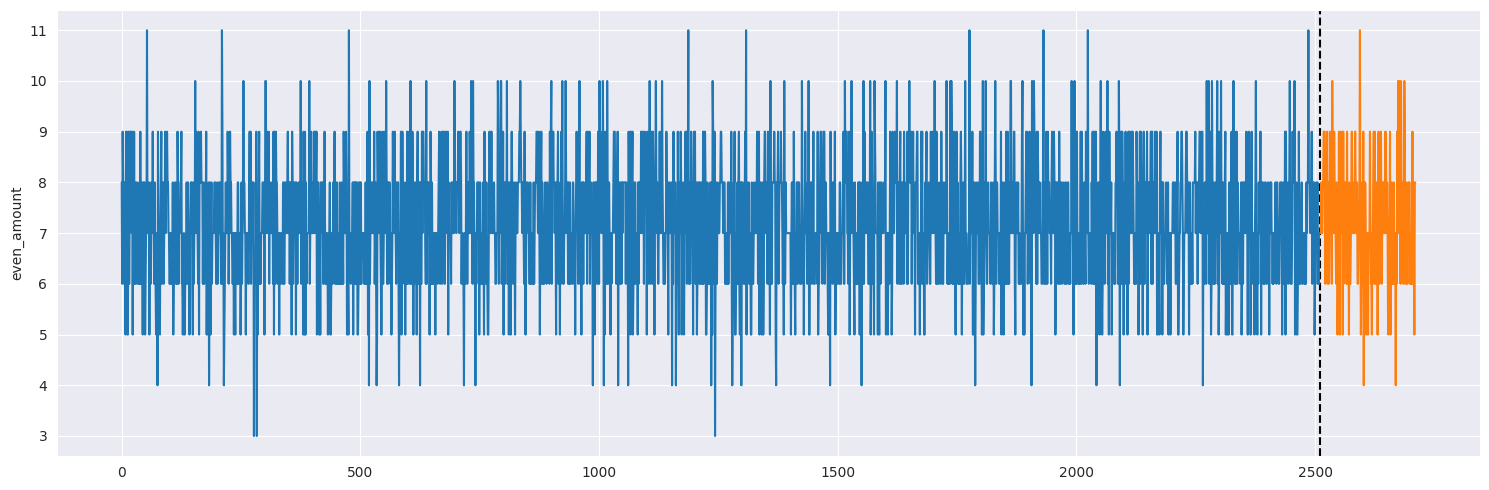

time: 1.37 s (started: 2023-07-26 17:10:57 +00:00)


In [78]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.lineplot(x=train_set.index, y=train_set['even_amount'], ax=axs)
sns.lineplot(x=test_set.index, y=test_set['even_amount'], ax=axs)

plt.tight_layout()
plt.show()

# Data Labeling

In [79]:
from scipy.stats import mode

time: 529 µs (started: 2023-07-26 17:10:59 +00:00)


In [80]:
def lag_window_features(ds, feature_name):
  ds = ds.copy()
  cat = ['min', 'max', 'repeated', 'even_amount', 'quartiles_codified']
  num = ['mean', 'std']
  week = 5 # apenas dias úteis
  ds['lag_' + feature_name] = ds[feature_name].shift(1)
  ds['fwd_' + feature_name] = ds[feature_name].shift(-1)
  if feature_name in cat:
    ds['wind_' + str(week) + '_' + feature_name] = ds[feature_name].rolling(window=week).apply(lambda x: mode(x, keepdims=True)[0])
  else:
    ds['wind_' + str(week) + '_' + feature_name] = ds[feature_name].rolling(window=week).mean()
  ds = ds.dropna()
  return ds



def create_labels(ds, feature_name):
  ds = lag_window_features(ds, feature_name)
  label_name = 'fwd_' + feature_name
  y = ds[label_name]
  X = ds.drop(label_name, axis=1)
  return X, y

time: 1.49 ms (started: 2023-07-26 17:10:59 +00:00)


In [81]:
label_name = 'repeated'
X_train, y_train  = create_labels(train_set, label_name)
X_test, y_test    = create_labels(test_set, label_name)

time: 1.64 s (started: 2023-07-26 17:10:59 +00:00)


# Model Training

In [82]:
from sklearn.ensemble            import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics             import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput         import MultiOutputClassifier
from sklearn.utils.class_weight  import compute_class_weight
from keras.callbacks             import EarlyStopping, ReduceLROnPlateau
from keras.layers                import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.models                import Sequential, Model
from keras.optimizers            import Nadam
from keras.wrappers.scikit_learn import KerasClassifier

import lightgbm as lgb

time: 2.26 ms (started: 2023-07-26 17:11:00 +00:00)


Class Weights Computing

In [83]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {key:value for key, value in zip(classes, weights)}
print(class_weights)

{5.0: 250.5, 6.0: 6.77027027027027, 7.0: 1.0659574468085107, 8.0: 0.4008, 9.0: 0.30736196319018405, 10.0: 0.4579524680073126, 11.0: 1.2715736040609138, 12.0: 6.2625, 13.0: 35.785714285714285, 14.0: 250.5}
time: 19 ms (started: 2023-07-26 17:11:01 +00:00)


Class Mapping

In [84]:
class_mapping    = {value:key for key, value in enumerate(classes)}
class_mapping_rw = {key:value for key, value in enumerate(classes)}
print(class_mapping)
print(class_mapping_rw)

{5.0: 0, 6.0: 1, 7.0: 2, 8.0: 3, 9.0: 4, 10.0: 5, 11.0: 6, 12.0: 7, 13.0: 8, 14.0: 9}
{0: 5.0, 1: 6.0, 2: 7.0, 3: 8.0, 4: 9.0, 5: 10.0, 6: 11.0, 7: 12.0, 8: 13.0, 9: 14.0}
time: 4.95 ms (started: 2023-07-26 17:11:01 +00:00)


### RandomForestClassifier

In [85]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
print(f'accuracy score: {accuracy_score(y_train, y_pred):.2f}')
print(classification_report(y_train, y_pred))

accuracy score: 1.00
              precision    recall  f1-score   support

         5.0       1.00      1.00      1.00         1
         6.0       1.00      1.00      1.00        37
         7.0       1.00      1.00      1.00       235
         8.0       1.00      1.00      1.00       625
         9.0       1.00      1.00      1.00       815
        10.0       1.00      1.00      1.00       547
        11.0       1.00      1.00      1.00       197
        12.0       1.00      1.00      1.00        40
        13.0       1.00      1.00      1.00         7
        14.0       1.00      1.00      1.00         1

    accuracy                           1.00      2505
   macro avg       1.00      1.00      1.00      2505
weighted avg       1.00      1.00      1.00      2505

time: 1.37 s (started: 2023-07-26 17:11:01 +00:00)


### LSTM
Reshaping train/test sets.

In [86]:
X_train_lstm = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm  = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_lstm = y_train.replace(to_replace=class_mapping)
y_test_lstm  = y_test.replace(to_replace=class_mapping)

time: 8.09 ms (started: 2023-07-26 17:11:02 +00:00)


Definindo as callbacks.

In [87]:
#callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

time: 668 µs (started: 2023-07-26 17:11:02 +00:00)


In [94]:
output_size = len(np.unique(y_train_lstm))

nn = Sequential()
nn.add(LSTM(units=300, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
nn.add(LSTM(units=300, activation='relu', return_sequences=True))
nn.add(LSTM(units=300, activation='relu'))
nn.add(Dense(units=output_size, activation='softmax'))

nn.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nn.fit(X_train_lstm, y_train_lstm,
                 validation_data=(X_test_lstm, y_test_lstm), epochs=20,
                 callbacks=[early_stopping_cb, lr_performance], verbose=True)

Epoch 1/20
79/79 [==============================] - 24s 260ms/step - loss: 1.7408 - accuracy: 0.2934 - val_loss: 1.6728 - val_accuracy: 0.3436 - lr: 0.0010
Epoch 2/20
79/79 [==============================] - 15s 187ms/step - loss: 1.6428 - accuracy: 0.3058 - val_loss: 1.6910 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 3/20
79/79 [==============================] - 13s 169ms/step - loss: 1.6353 - accuracy: 0.3186 - val_loss: 1.6306 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 4/20
79/79 [==============================] - 20s 254ms/step - loss: 1.6302 - accuracy: 0.3166 - val_loss: 1.6351 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 5/20
79/79 [==============================] - 14s 177ms/step - loss: 1.6264 - accuracy: 0.3194 - val_loss: 1.6365 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 6/20
79/79 [==============================] - 17s 221ms/step - loss: 1.6273 - accuracy: 0.3174 - val_loss: 1.6268 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 7/20
79/79 [==============================] - 21s 267ms/st

time: 5min 26s (started: 2023-07-26 17:14:29 +00:00)
